In [1]:
# Import necessary libraries
import os
import math
import re
import pickle
import random
import Levenshtein
import torch
import nltk
import seaborn as sns
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.tensorboard import SummaryWriter
from matplotlib import gridspec
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
from sklearn.metrics import confusion_matrix
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
# Read the data directory and file paths
data_dir = r"C:\Users\13658\Desktop\LaTex_Code_Generator"
handwritten_equations = os.path.join(data_dir, "Handwritten_equations")
json_dict = os.path.join(data_dir, "char_dict.json")
csv_file = os.path.join(data_dir, "caption_data.csv")

In [3]:
# Clean and merge spaces in LaTeX code intelligently
def smart_clean_latex(code):
    preserved = re.findall(r'(\\[a-zA-Z]+)\s+', code)
    for cmd in preserved:
        code = code.replace(cmd + ' ', f'{cmd}<<<SPACE>>>')
    code = code.replace(' ', '')
    code = code.replace('<<<SPACE>>>', ' ')
    return code

# Load the CSV file and process LaTeX codes
csv_data = pd.read_csv(csv_file)
latex_codes_raw = csv_data['Column2'].values.tolist()
latex_codes = [smart_clean_latex(str(code)) for code in latex_codes_raw]
image_names = csv_data['Column1'].values.tolist()

In [4]:
# Extract all LaTeX command tokens from the cleaned LaTeX codes
command_tokens = set()
for code in latex_codes:
    i = 0
    while i < len(code):
        if code[i] == '\\':
            j = i + 1
            while j < len(code) and code[j].isalpha():
                j += 1
            command_tokens.add(code[i:j])
            i = j
        else:
            i += 1

# Tokenize LaTeX code into a mix of full commands and individual characters
def mixed_tokenize_latex(code, command_set):
    tokens = []
    i = 0
    while i < len(code):
        if code[i] == '\\':
            j = i + 1
            while j < len(code) and code[j].isalpha():
                j += 1
            cmd = code[i:j]
            if cmd in command_set:
                tokens.append(cmd)
                i = j
                continue
        tokens.append(code[i])
        i += 1
    return tokens

# Count token frequencies across all LaTeX codes
token_counter = Counter()
for code in latex_codes:
    tokens = mixed_tokenize_latex(code, command_tokens)
    token_counter.update(tokens)

# Define special tokens and build token-index dictionaries
special_tokens = ['<pad>', '<s>', '</s>']
token_list = special_tokens + sorted(token_counter.keys())

token2idx = {token: idx for idx, token in enumerate(token_list)}
idx2token = {idx: token for token, idx in token2idx.items()}
vocab_size = len(token2idx)

# Encode LaTeX code into a sequence of token indices
def encode_label_mixed(code, token2idx, command_set, max_len):
    tokens = ['<s>'] + mixed_tokenize_latex(code, command_set)[:max_len - 2] + ['</s>']
    label = np.zeros(max_len, dtype=np.int32)
    for t, token in enumerate(tokens):
        label[t] = token2idx.get(token, 0)
    return label

max_seq_length = max(len(mixed_tokenize_latex(code, command_tokens)) for code in latex_codes) + 2
print(f"Dic Length: {vocab_size}")
print(f"Maximum Sequence: {max_seq_length}")

Dic Length: 136
Maximum Sequence: 224


In [5]:
train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomRotation(degrees=2),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
])

def apply_augmentation(image_tensor):
    return train_transform(image_tensor)

In [6]:
# Preprocess a single image: grayscale, resize with padding, normalize, and expand to 3 channels
def preprocess_image(image_path, target_size=(512, 128)):
    img = Image.open(image_path).convert('L')
    img.thumbnail(target_size, Image.Resampling.LANCZOS)

    delta_w = target_size[0] - img.size[0]
    delta_h = target_size[1] - img.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    img = ImageOps.expand(img, padding, fill=255)

    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.repeat(img_array, 3, axis=0)
    return torch.from_numpy(img_array).float()

# Define a custom dataset for LaTeX images and labels
class LatexDataset(Dataset):
    def __init__(self, image_dir, image_names, latex_codes, max_len, augment=False):
        self.image_dir = image_dir
        self.image_names = image_names
        self.latex_codes = latex_codes
        self.max_len = max_len
        self.augment = augment

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, f"{self.image_names[idx]}.bmp")
        img = preprocess_image(img_path)

        if self.augment:
            img = apply_augmentation(img)

        label = encode_label_mixed(self.latex_codes[idx], token2idx, command_tokens, self.max_len)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor

# Define a custom collate function to batch images and pad label sequences
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    return images, labels, [len(l) for l in labels]

# Split the dataset into training, validation, and test sets (70% / 15% / 15%)
train_imgs, tep_imgs, train_codes, tep_codes = train_test_split(
    image_names, latex_codes, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_codes, test_codes = train_test_split(
    tep_imgs, tep_codes, test_size=0.5, random_state=41)

# Splited dataset statistics
train_dataset = LatexDataset(handwritten_equations, train_imgs, train_codes, max_seq_length, augment=True)
val_dataset = LatexDataset(handwritten_equations, val_imgs, val_codes, max_seq_length, augment=False)
test_dataset = LatexDataset(handwritten_equations, test_imgs, test_codes, max_seq_length, augment=False)

# Data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

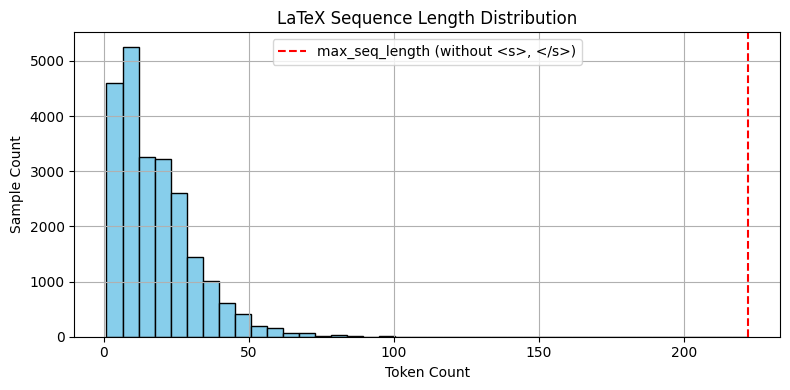

In [7]:
# Create directory for saving token dictionaries
dict_dir = os.path.join(data_dir, "token_dicts")
os.makedirs(dict_dir, exist_ok=True)

# Save token2idx and idx2token mappings as pickle files
with open(os.path.join(dict_dir, "token2idx.pkl"), "wb") as f:
    pickle.dump(token2idx, f)

with open(os.path.join(dict_dir, "idx2token.pkl"), "wb") as f:
    pickle.dump(idx2token, f)

# Plot the histogram of LaTeX sequence lengths
seq_lens = [len(mixed_tokenize_latex(code, command_tokens)) for code in latex_codes]
plt.figure(figsize=(8, 4))
plt.hist(seq_lens, bins=40, color='skyblue', edgecolor='black')
plt.axvline(max_seq_length - 2, color='red', linestyle='--', label='max_seq_length (without <s>, </s>)')
plt.title("LaTeX Sequence Length Distribution")
plt.xlabel("Token Count")
plt.ylabel("Sample Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Figure shape: torch.Size([3, 128, 512])
Label shape: torch.Size([224])


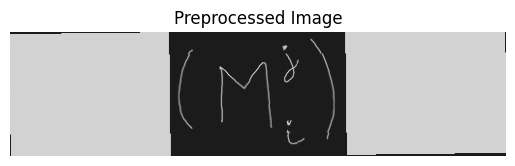

In [8]:
# Visualize a random preprosessed image and its corresponding LaTeX code
idx = random.randint(0, len(train_dataset) - 1)
img_tensor, label_tensor = train_dataset[idx]

print(f"Figure shape: {img_tensor.shape}")
print(f"Label shape: {label_tensor.shape}")

plt.imshow(img_tensor.permute(1, 2, 0).numpy(), cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

In [9]:
# Decode and display the LaTeX expression for the selected image
sample_indices = random.sample(range(len(train_dataset)), 5)

for i, idx in enumerate(sample_indices, 1):
    img_tensor, label_tensor = train_dataset[idx]
    
    tokens = [idx2token[idx.item()] for idx in label_tensor 
              if idx.item() not in (token2idx['<pad>'], token2idx['<s>'], token2idx['</s>'])]
    decoded_latex = ' '.join(tokens)

    print(f"\nSample {i}")
    print("Token Length:", len(tokens))
    print("Restore the LaTeX expression:")
    print(decoded_latex)


Sample 1
Token Length: 1
Restore the LaTeX expression:
j

Sample 2
Token Length: 14
Restore the LaTeX expression:
\frac   { 2 ^ { 5 } } { 3 + 1 }

Sample 3
Token Length: 6
Restore the LaTeX expression:
n ^ { - k }

Sample 4
Token Length: 18
Restore the LaTeX expression:
{ q \gt   { \mathrm   { ~ A ~ } } ^ { d } }

Sample 5
Token Length: 30
Restore the LaTeX expression:
\sum   _ { n = 1 } ^ { N } \left ( - 1 \right ) ^ { n } \sin   \left ( n x \right )


In [10]:
# Decode and display a random LaTeX code from the dataset
sample_idx = random.randint(0, len(latex_codes_raw) - 1)
raw = latex_codes_raw[sample_idx]
cleaned = smart_clean_latex(raw)
encoded = encode_label_mixed(cleaned, token2idx, command_tokens, max_seq_length)

tokens = [idx2token[i] for i in encoded if i not in (token2idx['<pad>'], token2idx['<s>'], token2idx['</s>'])]
decoded = ''.join(tokens)

print("Original Lable:")
print(raw)
print("\nWashed:")
print(cleaned)
print("\nEncoded:")
print(encoded)
print("\nDecoded:")
print(decoded)

Original Lable:
8 9 \times ( 1 6 3 \times 4 0 ) \leq 5 8 0 2 8 0

Washed:
89\times (163\times 40)\leq 580280

Encoded:
[  1  22  23 100   3   6  15  20  17 100   3  18  14   7  75   3  19  22
  14  16  22  14   2   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 

In [11]:
# Print the shapes and label lengths for inspection
batch = next(iter(train_loader))
imgs, labels, lengths = batch

print(f"Batch figure shape: {imgs.shape}")
print(f"Batch label shape: {labels.shape}")
print(f"Label Length (first 5): {lengths[:5]}")

Batch figure shape: torch.Size([32, 3, 128, 512])
Batch label shape: torch.Size([32, 224])
Label Length (first 5): [224, 224, 224, 224, 224]


In [12]:
# Define 2D positional encoding for CNN feature maps
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, height, width):
        super().__init__()
        if d_model % 4 != 0:
            raise ValueError("d_model must be divisible by 4")

        self.d_model = d_model
        self.height = height
        self.width = width
        
        pe = torch.zeros(d_model, height, width) # Initialize a zero tensor for positional encoding

        d_model_half = d_model // 2
        div_term = torch.exp(torch.arange(0., d_model_half, 2) * -(math.log(10000.0) / d_model_half))

        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)

        # Horizontal coding (width direction)
        pe[0:d_model_half:2, :, :] = torch.sin(pos_w * div_term).T.unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model_half:2, :, :] = torch.cos(pos_w * div_term).T.unsqueeze(1).repeat(1, height, 1)

        # Vertical encoding (height direction)
        pe[d_model_half::2, :, :] = torch.sin(pos_h * div_term).T.unsqueeze(2).repeat(1, 1, width)
        pe[d_model_half+1::2, :, :] = torch.cos(pos_h * div_term).T.unsqueeze(2).repeat(1, 1, width)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :, :x.size(2), :x.size(3)]

In [13]:
# Define the Encoder class using ResNet34 as the backbone
class Encoder(nn.Module):
    def __init__(self, d_model=384):
        super().__init__()
        base_cnn = resnet34(pretrained=True)
        self.backbone = nn.Sequential(*list(base_cnn.children())[:6])

        self.project = nn.Conv2d(128, d_model, kernel_size=1)
        self.row_encoder = nn.LSTM(input_size=d_model,
                                   hidden_size=d_model // 2,
                                   batch_first=True,
                                   bidirectional=True)

        self.pe = None

    def forward(self, x):
        feat = self.backbone(x)
        feat = self.project(feat)
        B, C, H, W = feat.shape

        if self.pe is None:
            self.pe = PositionalEncoding2D(C, H, W).to(x.device)
        feat = self.pe(feat)

        # Run Row-wise LSTM
        feat = feat.permute(0, 2, 3, 1).contiguous()
        feat = feat.view(B * H, W, C)
        feat, _ = self.row_encoder(feat)
        feat = feat.view(B, H, W, C)

        return feat

In [14]:
# Run train loader to get a batch of images
images, _, _ = next(iter(train_loader))
images = images.cuda()

# Encoder initialization
encoder = Encoder(d_model=256).cuda()

# Forward Pass
features = encoder(images)

print("Encoder Output:", features.shape)

c:\Users\13658\Desktop\LaTex_Code_Generator\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\13658\Desktop\LaTex_Code_Generator\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoder Output: torch.Size([32, 16, 64, 256])


In [15]:
# Show the images on different layers of the encoder
class VisualCNN(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet34(pretrained=True)
        self.stages = nn.ModuleList([
            nn.Sequential(base.conv1, base.bn1, base.relu),  # stage 0
            base.maxpool,                                    # stage 1
            base.layer1,                                     # stage 2
            base.layer2,                                     # stage 3
            base.layer3                                      # stage 4
        ])

    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

In [16]:
# Visualize the feature maps from the CNN
def show_feature_map(tensor, title, max_channels=4):
    n = min(max_channels, tensor.shape[1])  # Show first n channels
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))
    for i in range(n):
        axes[i].imshow(tensor[0, i].detach().cpu(), cmap='gray')
        axes[i].set_title(f"{title} | Channel {i}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

Stage 0 output shape: torch.Size([1, 64, 64, 256])


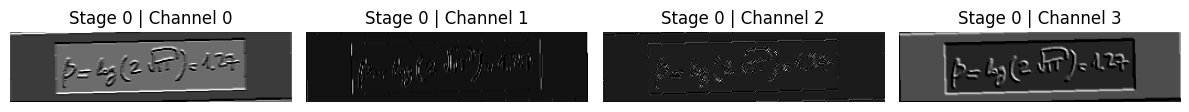

Stage 1 output shape: torch.Size([1, 64, 32, 128])


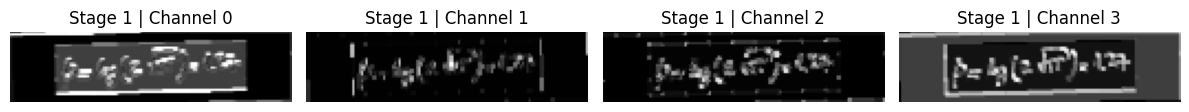

Stage 2 output shape: torch.Size([1, 64, 32, 128])


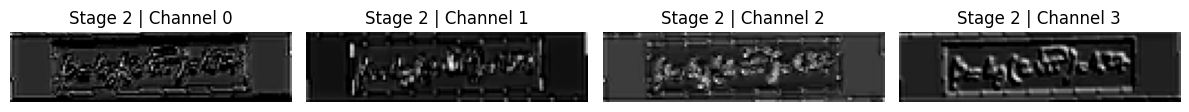

Stage 3 output shape: torch.Size([1, 128, 16, 64])


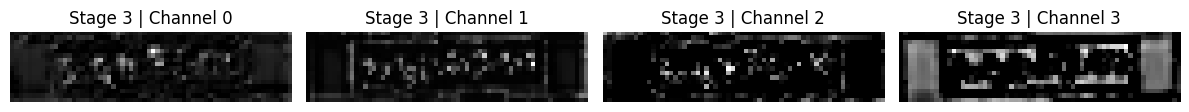

Stage 4 output shape: torch.Size([1, 256, 8, 32])


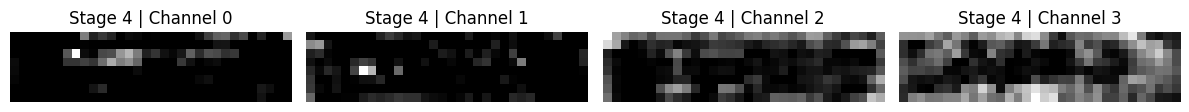

In [17]:
# Get a batch of images from the train loader
images, _, _ = next(iter(train_loader))
sample_img = images[0:1].cuda()

# Instantiate the VisualCNN and get feature maps
viz_cnn = VisualCNN().cuda()
features = viz_cnn(sample_img)

# Show every stage's feature map
for idx, feat in enumerate(features):
    print(f"Stage {idx} output shape: {feat.shape}")
    show_feature_map(feat, f"Stage {idx}")

In [18]:
# Show the maximum activation of the feature map
def show_max_activation(feature_map, title="Max Activation"):
    
    max_activations = torch.max(feature_map[0], dim=0).values.detach().cpu()
    
    plt.figure(figsize=(6, 4))
    plt.imshow(max_activations, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

Stage 0 output shape: torch.Size([1, 64, 64, 256])


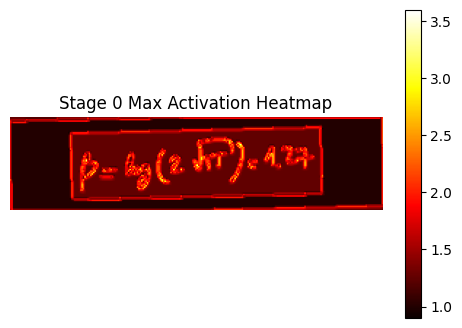

Stage 1 output shape: torch.Size([1, 64, 32, 128])


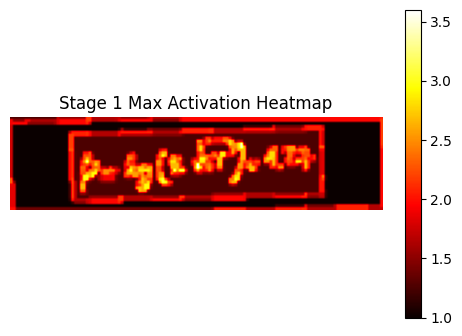

Stage 2 output shape: torch.Size([1, 64, 32, 128])


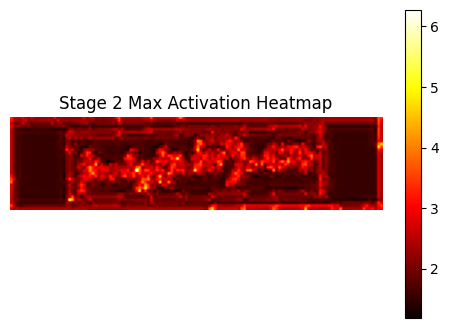

Stage 3 output shape: torch.Size([1, 128, 16, 64])


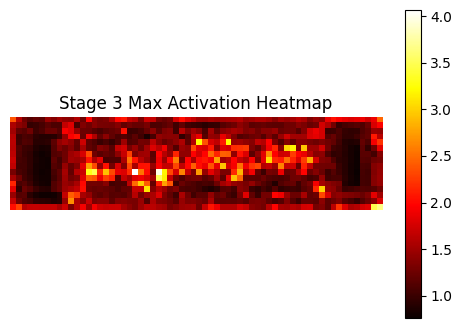

Stage 4 output shape: torch.Size([1, 256, 8, 32])


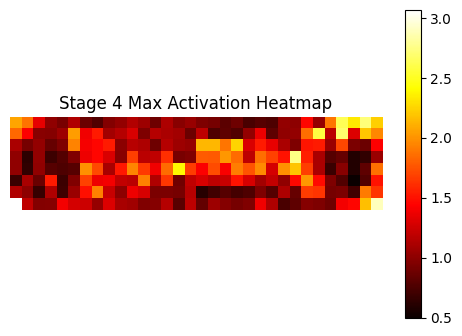

In [19]:
# Show the maximum activation of each stage's feature map
for idx, feat in enumerate(features):
    print(f"Stage {idx} output shape: {feat.shape}")
    show_max_activation(feat, f"Stage {idx} Max Activation Heatmap")

In [20]:
# Define the Decoder class using Transformer Decoder layers
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model=384, nhead=8, num_layers=8, max_len=256, dropout=0.1):
        super().__init__()

        # Token embedding layer (maps token indices to vectors)
        self.token_embedding = nn.Embedding(vocab_size, d_model)

         # Learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len * 2, d_model))

         # Learnable positional embeddings
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size)

        nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, tgt_input, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None):

        tgt_emb = self.token_embedding(tgt_input) + self.pos_embedding[:, :tgt_input.size(1), :]

        memory = memory.reshape(memory.size(0), -1, memory.size(-1))

        output = self.transformer_decoder(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )
        return self.output_layer(output)

In [21]:
# Generate a square mask for sequence-to-sequence decoding
# Masked positions are filled with -inf, non-masked with 0.0
def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [22]:
# Pack the Encoder and Decoder into a single model
class Im2LatexModel(nn.Module):
    def __init__(self, vocab_size, d_model=384, max_seq_len=256):
        super().__init__()
        self.encoder = Encoder(d_model=d_model)
        self.decoder = Decoder(vocab_size=vocab_size, d_model=d_model, max_len=max_seq_len)
        self.max_seq_len = max_seq_len

    def forward(self, images, tgt_input, tgt_mask=None):
        enc_output = self.encoder(images)  # [B, H, W, D]
        logits = self.decoder(tgt_input, enc_output, tgt_mask=tgt_mask)
        return logits  # [B, T, vocab_size]

In [23]:
# Teset the model with a batch of images and labels
images, labels, _ = next(iter(train_loader))
images = images.cuda()
labels = labels.cuda()

# Create input by shifting
tgt_input = labels[:, :-1]
tgt_output = labels[:, 1:]

model = Im2LatexModel(vocab_size=len(token2idx), d_model=256, max_seq_len=max_seq_length).cuda()
tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(images.device)

logits = model(images, tgt_input, tgt_mask)  # [B, T, vocab_size]

print("Decoder output:", logits.shape)

Decoder output: torch.Size([32, 223, 136])


In [24]:
# Test the integrity of the decoder
def test_decoder_integrity(model, images, labels, token2idx, idx2token):
    print("=" * 50)
    print("Running Decoder Integrity Tests")
    print("=" * 50)

    device = next(model.parameters()).device
    images, labels = images.to(device), labels.to(device)
    tgt_input = labels[:, :-1]
    tgt_output = labels[:, 1:]
    tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

    # Forward
    logits = model(images, tgt_input, tgt_mask)

    # Test 1 - Logits stats
    print("\n[1] Logits distribution:")
    print("   mean:", logits.mean().item())
    print("   max :", logits.max().item())
    print("   min :", logits.min().item())

    # Test 2 - Sample Top-K token at t=10
    t = min(10, logits.size(1) - 1)
    sample_logits = logits[0, t]
    probs = torch.softmax(sample_logits, dim=-1)
    topk_probs, topk_idx = torch.topk(probs, k=5)

    print("\n[2] Top-5 tokens at timestep", t)
    for i in range(5):
        print(f"   {idx2token[topk_idx[i].item()]}: {topk_probs[i].item():.4f}")

    # Test 3 - First-step decoder only
    print("\n[3] First-step decoding test")
    start = torch.full((1, 1), token2idx['<s>'], dtype=torch.long).to(device)
    enc_out = model.encoder(images[0:1])
    logits_start = model.decoder(start, enc_out)
    pred = torch.argmax(logits_start, dim=-1)[0, 0].item()
    print(f"   Predicted first token: {idx2token[pred]}")

    # Test 4 - Gradient check
    print("\n[4] Gradient flow check")
    logits_flat = logits.view(-1, logits.size(-1))
    labels_flat = tgt_output.contiguous().view(-1)
    loss_fn = nn.CrossEntropyLoss(ignore_index=token2idx['<pad>'])
    loss = loss_fn(logits_flat, labels_flat)
    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"   {name:40s} | grad norm = {param.grad.norm():.4f}")

    print("\nDecoder passed all integrity checks (forward & backward).\n")

In [25]:
# Test the decoder integrity with a batch of images and labels
images, labels, _ = next(iter(train_loader))
test_decoder_integrity(model, images, labels, token2idx, idx2token)

Running Decoder Integrity Tests

[1] Logits distribution:
   mean: -0.09978057444095612
   max : 2.140646457672119
   min : -2.324622392654419

[2] Top-5 tokens at timestep 10
   \ldots: 0.0306
   X: 0.0193
   H: 0.0187
   \lambda: 0.0179
   _: 0.0178

[3] First-step decoding test
   Predicted first token: \vtop

[4] Gradient flow check
   encoder.backbone.0.weight                | grad norm = 0.0482
   encoder.backbone.1.weight                | grad norm = 0.0075
   encoder.backbone.1.bias                  | grad norm = 0.0019
   encoder.backbone.4.0.conv1.weight        | grad norm = 0.0153
   encoder.backbone.4.0.bn1.weight          | grad norm = 0.0029
   encoder.backbone.4.0.bn1.bias            | grad norm = 0.0031
   encoder.backbone.4.0.conv2.weight        | grad norm = 0.0100
   encoder.backbone.4.0.bn2.weight          | grad norm = 0.0060
   encoder.backbone.4.0.bn2.bias            | grad norm = 0.0018
   encoder.backbone.4.1.conv1.weight        | grad norm = 0.0133
   encoder.

In [26]:
# Loss function for training (label smoothing)
def create_loss_function(token2idx, smoothing=0.1):
    ignore_index = token2idx['<pad>']
    return nn.CrossEntropyLoss(ignore_index=ignore_index, label_smoothing=smoothing)

In [27]:
# Define the one-epoch training function
def train_one_epoch(model, dataloader, optimizer, scheduler, loss_fn, device):
    model.train()
    total_loss = 0

    for images, labels, _ in tqdm(dataloader, desc="Training"):
        # Use GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Prepare target input (for prediction) and target output (for supervision)
        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:]

        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        optimizer.zero_grad()
        logits = model(images, tgt_input, tgt_mask)

        # Reshape logits and targets for loss computation
        logits = logits.view(-1, logits.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

         # Compute loss and backpropagate
        loss = loss_fn(logits, tgt_output)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [28]:
# Define the evaluation function (no gradient calculation)
@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0

    for images, labels, _ in tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:]

        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        logits = model(images, tgt_input, tgt_mask)
        logits = logits.view(-1, logits.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

        loss = loss_fn(logits, tgt_output)
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [29]:
# Define a learning rate scheduler with linear warmup and cosine annealing
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, 
            0.5 * (1.0 + math.cos(math.pi * (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps)))
        )
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [30]:
# Define the full training loop with validation and checkpoint saving
def fit(model, train_loader, val_loader, token2idx, epochs=10, lr=1e-4, device="cuda"):
    # Setup optimizer, loss function, scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = create_loss_function(token2idx, smoothing=0.1)

    num_training_steps = epochs * len(train_loader)
    num_warmup_steps = int(0.1 * num_training_steps)  # warmup 10% step
    scheduler = get_scheduler(optimizer, num_warmup_steps, num_training_steps)

    best_val_loss = float('inf')
    save_path = "best_model.pt"

    writer = SummaryWriter(log_dir="runs/im2latex")

    train_losses = []
    val_losses = []

    # Measure initial loss before training
    print("\nMeasuring Initial Loss...")
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        images, labels, _ = batch
        images, labels = images.to(device), labels.to(device)

        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:]
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        logits = model(images, tgt_input, tgt_mask)
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
        print(f"Initial Loss (on val batch): {loss.item():.4f}")

     # Start training loop
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model to {save_path}")

    writer.close()

    # Plot loss curve
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_curve.png")
    plt.show()
    print("Saved loss curve to loss_curve.png")

In [31]:
# Start training the model
model = Im2LatexModel(
    vocab_size=len(token2idx),
    d_model=384,
    max_seq_len=max_seq_length
).to("cuda")

fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    token2idx=token2idx,
    epochs=50,
    lr=1e-4,
    device="cuda"
)


Measuring Initial Loss...
Initial Loss (on val batch): 5.2383

Epoch 1/50


Training:   0%|          | 0/503 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def beam_search_decode(model, image, token2idx, idx2token, beam_width=3, max_len=256, device="cuda", length_penalty_alpha=0.6):
    model.eval()

    if not image.is_cuda:
        image = image.to(device)

    with torch.no_grad():
        memory = model.encoder(image.unsqueeze(0))
        memory = memory.expand(beam_width, *memory.shape[1:])

        sequences = [[token2idx['<s>']] for _ in range(beam_width)]
        scores = torch.zeros(beam_width, device=device)
        completed = []

        for step in range(max_len):
            all_candidates = []
            for i, seq in enumerate(sequences):
                if len(seq) > 1 and seq[-1] == token2idx['</s>']:
                    length_penalty = (len(seq)) ** length_penalty_alpha
                    completed.append((seq, scores[i].item() / length_penalty))
                    continue

                tgt_input = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
                tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
                output = model.decoder(tgt_input, memory[i:i+1], tgt_mask)
                probs = torch.log_softmax(output[0, -1], dim=-1)

                topk_probs, topk_idx = torch.topk(probs, beam_width)
                for j in range(beam_width):
                    candidate = seq + [topk_idx[j].item()]
                    score = scores[i] + topk_probs[j]
                    all_candidates.append((candidate, score))

            all_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            sequences = [cand[0] for cand in all_candidates]
            scores = torch.tensor([cand[1] for cand in all_candidates], device=device)

        for i, seq in enumerate(sequences):
            length_penalty = (len(seq)) ** length_penalty_alpha
            completed.append((seq, scores[i].item() / length_penalty))

        completed = sorted(completed, key=lambda x: x[1], reverse=True)

        best_seq = completed[0][0]
        return [idx2token[idx] for idx in best_seq[1:-1] if idx in idx2token]

In [ ]:
@torch.no_grad()
def evaluate_model_with_beam(model, dataset, token2idx, idx2token, num_samples, beam_width=3, max_len=256, visualize=True):
    model.eval()
    correct = 0
    total = 0

    device = next(model.parameters()).device

    def tokens_to_str(tokens):
        return ''.join(t for t in tokens if t not in ['<s>', '</s>', '<pad>'])

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)
        
        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device, length_penalty_alpha=0.6)
        true_tokens = [idx2token[idx.item()] for idx in label if idx.item() != token2idx['<pad>']]

        pred_str = tokens_to_str(pred_tokens)
        true_str = tokens_to_str(true_tokens)

        match = pred_str == true_str
        correct += int(match)
        total += 1

        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            axes[0].imshow(image.permute(1, 2, 0).squeeze().cpu(), cmap='gray')
            axes[0].set_title("Input Image")
            axes[0].axis("off")

            axes[1].text(0.5, 0.7, f"GT: ${true_str}$", ha='center', fontsize=12)
            axes[1].text(0.5, 0.3, f"Pred: ${pred_str}$", ha='center', fontsize=12, color=('green' if match else 'red'))
            axes[1].axis("off")
            plt.show()

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    acc = correct / total
    print(f"\nBeam Search Accuracy (exact match): {acc * 100:.2f}%")
    return acc

In [ ]:
evaluate_model_with_beam(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3,
    visualize=False
)

Processed 100/3448 samples...
Processed 200/3448 samples...
Processed 300/3448 samples...
Processed 400/3448 samples...
Processed 500/3448 samples...
Processed 600/3448 samples...
Processed 700/3448 samples...
Processed 800/3448 samples...
Processed 900/3448 samples...
Processed 1000/3448 samples...
Processed 1100/3448 samples...
Processed 1200/3448 samples...
Processed 1300/3448 samples...
Processed 1400/3448 samples...
Processed 1500/3448 samples...
Processed 1600/3448 samples...
Processed 1700/3448 samples...
Processed 1800/3448 samples...
Processed 1900/3448 samples...
Processed 2000/3448 samples...
Processed 2100/3448 samples...
Processed 2200/3448 samples...
Processed 2300/3448 samples...
Processed 2400/3448 samples...
Processed 2500/3448 samples...
Processed 2600/3448 samples...
Processed 2700/3448 samples...
Processed 2800/3448 samples...
Processed 2900/3448 samples...
Processed 3000/3448 samples...
Processed 3100/3448 samples...
Processed 3200/3448 samples...
Processed 3300/34

0.7198375870069605

In [ ]:
def evaluate_token_level_accuracy(model, dataset, token2idx, idx2token, num_samples=50, beam_width=3, max_len=256):
    model.eval()
    total_tokens = 0
    correct_tokens = 0

    device = next(model.parameters()).device
    print(f"Evaluating on device: {device}")

    def strip_tokens(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device, length_penalty_alpha=0.6)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip_tokens(pred_tokens)
        true = strip_tokens(true_tokens)

        for p, t in zip(pred, true):
            total_tokens += 1
            if p == t:
                correct_tokens += 1

        total_tokens += abs(len(pred) - len(true))

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0.0
    print(f"Token-level accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [ ]:
accuracy = evaluate_token_level_accuracy(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3
)

Evaluating on device: cuda:0
Processed 100/3448 samples...
Processed 200/3448 samples...
Processed 300/3448 samples...
Processed 400/3448 samples...
Processed 500/3448 samples...
Processed 600/3448 samples...
Processed 700/3448 samples...
Processed 800/3448 samples...
Processed 900/3448 samples...
Processed 1000/3448 samples...
Processed 1100/3448 samples...
Processed 1200/3448 samples...
Processed 1300/3448 samples...
Processed 1400/3448 samples...
Processed 1500/3448 samples...
Processed 1600/3448 samples...
Processed 1700/3448 samples...
Processed 1800/3448 samples...
Processed 1900/3448 samples...
Processed 2000/3448 samples...
Processed 2100/3448 samples...
Processed 2200/3448 samples...
Processed 2300/3448 samples...
Processed 2400/3448 samples...
Processed 2500/3448 samples...
Processed 2600/3448 samples...
Processed 2700/3448 samples...
Processed 2800/3448 samples...
Processed 2900/3448 samples...
Processed 3000/3448 samples...
Processed 3100/3448 samples...
Processed 3200/3448

In [ ]:
@torch.no_grad()
def evaluate_edit_distance(model, dataset, token2idx, idx2token, num_samples=50, beam_width=3, max_len=256):
    model.eval()
    total_ned = 0.0
    count = 0

    device = next(model.parameters()).device

    def strip_tokens(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device, length_penalty_alpha=0.6)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip_tokens(pred_tokens)
        true = strip_tokens(true_tokens)

        pred_str = ' '.join(pred)
        true_str = ' '.join(true)

        if len(true_str.strip()) == 0:
            continue

        lev_dist = Levenshtein.distance(pred_str, true_str)
        max_len_str = max(len(pred_str), len(true_str))
        ned = 1 - lev_dist / max_len_str
        total_ned += ned
        count += 1

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    avg_ned = total_ned / count if count > 0 else 0.0
    print(f"Normalized Edit Distance (NED): {avg_ned * 100:.2f}%")
    return avg_ned

In [ ]:
evaluate_edit_distance(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3
)

Processed 100/3448 samples...
Processed 200/3448 samples...
Processed 300/3448 samples...
Processed 400/3448 samples...
Processed 500/3448 samples...
Processed 600/3448 samples...
Processed 700/3448 samples...
Processed 800/3448 samples...
Processed 900/3448 samples...
Processed 1000/3448 samples...
Processed 1100/3448 samples...
Processed 1200/3448 samples...
Processed 1300/3448 samples...
Processed 1400/3448 samples...
Processed 1500/3448 samples...
Processed 1600/3448 samples...
Processed 1700/3448 samples...
Processed 1800/3448 samples...
Processed 1900/3448 samples...
Processed 2000/3448 samples...
Processed 2100/3448 samples...
Processed 2200/3448 samples...
Processed 2300/3448 samples...
Processed 2400/3448 samples...
Processed 2500/3448 samples...
Processed 2600/3448 samples...
Processed 2700/3448 samples...
Processed 2800/3448 samples...
Processed 2900/3448 samples...
Processed 3000/3448 samples...
Processed 3100/3448 samples...
Processed 3200/3448 samples...
Processed 3300/34

0.9186099199609508

In [ ]:
@torch.no_grad()
def export_predictions_to_csv(model, dataset, token2idx, idx2token, beam_width=3, max_len=256, num_samples=100, output_file="prediction_results.csv"):
    model.eval()
    results = []

    device = next(model.parameters()).device

    def strip_tokens(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip_tokens(pred_tokens)
        true = strip_tokens(true_tokens)

        pred_str = ' '.join(pred)
        true_str = ' '.join(true)

        sentence_match = pred == true

        if len(true) > 0:
            match_count = sum(p == t for p, t in zip(pred, true))
            token_accuracy = match_count / len(true)
        else:
            token_accuracy = 0.0

        if len(true_str.strip()) > 0:
            lev = Levenshtein.distance(pred_str, true_str)
            ned = 1 - lev / max(len(pred_str), len(true_str))
        else:
            ned = 0.0

        results.append({
            "index": i,
            "true_latex": true_str,
            "pred_latex": pred_str,
            "sentence_match": sentence_match,
            "token_accuracy(%)": round(token_accuracy * 100, 2),
            "normalized_edit_distance(%)": round(ned * 100, 2)
        })

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"Saved prediction results to: {output_file}")
    return df

In [ ]:
df_results = export_predictions_to_csv(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    beam_width=3,
    num_samples=len(test_dataset),
    output_file="latex_predictions.csv"
)

Processed 100/3448 samples...
Processed 200/3448 samples...
Processed 300/3448 samples...
Processed 400/3448 samples...
Processed 500/3448 samples...
Processed 600/3448 samples...
Processed 700/3448 samples...
Processed 800/3448 samples...
Processed 900/3448 samples...
Processed 1000/3448 samples...
Processed 1100/3448 samples...
Processed 1200/3448 samples...
Processed 1300/3448 samples...
Processed 1400/3448 samples...
Processed 1500/3448 samples...
Processed 1600/3448 samples...
Processed 1700/3448 samples...
Processed 1800/3448 samples...
Processed 1900/3448 samples...
Processed 2000/3448 samples...
Processed 2100/3448 samples...
Processed 2200/3448 samples...
Processed 2300/3448 samples...
Processed 2400/3448 samples...
Processed 2500/3448 samples...
Processed 2600/3448 samples...
Processed 2700/3448 samples...
Processed 2800/3448 samples...
Processed 2900/3448 samples...
Processed 3000/3448 samples...
Processed 3100/3448 samples...
Processed 3200/3448 samples...
Processed 3300/34

In [ ]:
def render_prediction_comparison(image_tensor, true_latex, pred_latex):
    plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # images
    ax0 = plt.subplot(gs[0])
    ax0.imshow(image_tensor.permute(1, 2, 0).squeeze(), cmap='gray')
    ax0.set_title("Input Image")
    ax0.axis("off")

    # GT LaTeX
    ax1 = plt.subplot(gs[1])
    ax1.text(0.5, 0.5, f"${true_latex}$", fontsize=18, ha='center', va='center')
    ax1.set_title("Ground Truth")
    ax1.axis("off")

    # Prediction LaTeX
    ax2 = plt.subplot(gs[2])
    ax2.text(0.5, 0.5, f"${pred_latex}$", fontsize=18, ha='center', va='center')
    ax2.set_title("Prediction")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

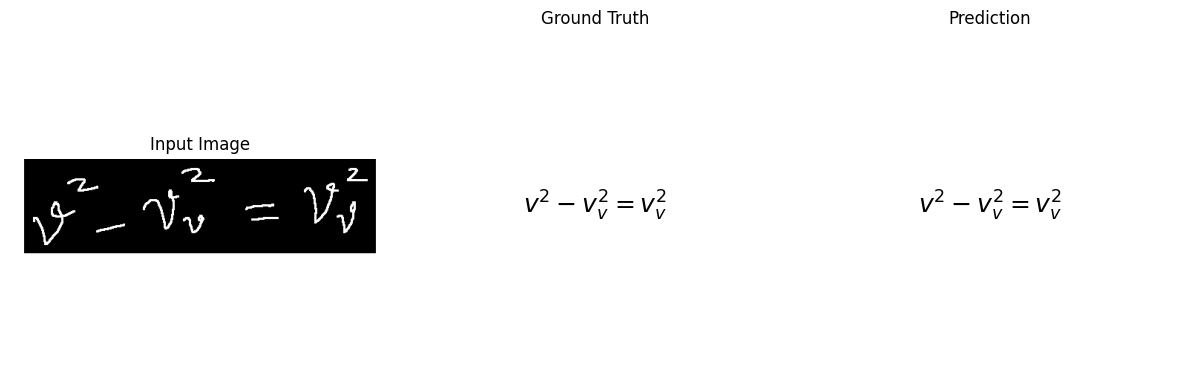

In [ ]:
index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[index]

pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width=3, device="cuda", length_penalty_alpha=0.6)
true_tokens = [idx2token[idx.item()] for idx in label]

def clean(toks): return ''.join(t for t in toks if t not in ['<s>', '</s>', '<pad>'])
true_str = clean(true_tokens)
pred_str = clean(pred_tokens)

render_prediction_comparison(image, true_str, pred_str)

In [ ]:
@torch.no_grad()
def build_confusion_matrix_gpu(model, dataset, token2idx, idx2token,
                                num_samples=200, beam_width=3, max_len=256, top_k_tokens=30):
    model.eval()
    true_labels = []
    pred_labels = []

    device = next(model.parameters()).device

    def strip(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device, length_penalty_alpha=0.6)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip(pred_tokens)
        true = strip(true_tokens)

        min_len = min(len(pred), len(true))
        true_labels.extend(true[:min_len])
        pred_labels.extend(pred[:min_len])

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    all_tokens = Counter(true_labels + pred_labels)
    most_common = [tok for tok, _ in all_tokens.most_common(top_k_tokens)]
    most_common_set = set(most_common)

    def map_tok(tok):
        return tok if tok in most_common_set else 'other'

    mapped_true = [map_tok(tok) for tok in true_labels]
    mapped_pred = [map_tok(tok) for tok in pred_labels]

    labels_sorted = sorted(set(mapped_true + mapped_pred))

    cm = confusion_matrix(mapped_true, mapped_pred, labels=labels_sorted)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.xlabel("Predicted Token")
    plt.ylabel("Ground Truth Token")
    plt.title(f"Confusion Matrix (Top {top_k_tokens} Tokens + 'other')")
    plt.tight_layout()
    plt.show()

    return cm, labels_sorted, true_labels, pred_labels

In [ ]:
def analyze_top_confusions(true_labels, pred_labels, top_k=10):
    assert len(true_labels) == len(pred_labels)

    confusions = Counter()

    for t, p in zip(true_labels, pred_labels):
        if t != p:
            confusions[(t, p)] += 1

    most_common_confusions = confusions.most_common(top_k)

    print(f"\nTop-{top_k} Most Common Confusions:")
    for (true_tok, pred_tok), count in most_common_confusions:
        print(f"  '{true_tok}' → '{pred_tok}' : {count} times")

    return most_common_confusions


In [ ]:
cm, labels_sorted, true_labels, pred_labels = build_confusion_matrix_gpu(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3,
    max_len=256,
    top_k_tokens=30
)

top_confusions = analyze_top_confusions(true_labels, pred_labels, top_k=15)

In [ ]:
@torch.no_grad()
def evaluate_bleu_score(model, dataset, token2idx, idx2token,
                        num_samples=100, beam_width=3, max_len=256):
    model.eval()
    device = next(model.parameters()).device

    bleu_scores = []

    smoothing_fn = SmoothingFunction().method4

    def strip_tokens(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token,
                                         beam_width=beam_width, max_len=max_len,
                                         device=device, length_penalty_alpha=0.6)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip_tokens(pred_tokens)
        true = strip_tokens(true_tokens)

        if len(true) == 0:
            continue

        bleu = sentence_bleu(
            [true], pred,
            weights=(0.25, 0.25, 0.25, 0.25),
            smoothing_function=smoothing_fn
        )
        bleu_scores.append(bleu)

        if (i + 1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
    print(f"\nAverage BLEU Score: {avg_bleu * 100:.2f}%")
    return avg_bleu

In [ ]:
bleu_score = evaluate_bleu_score(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3,
    max_len=256
)

Processed 100/3448 samples...
Processed 200/3448 samples...
Processed 300/3448 samples...
Processed 400/3448 samples...
Processed 500/3448 samples...
Processed 600/3448 samples...
Processed 700/3448 samples...
Processed 800/3448 samples...
Processed 900/3448 samples...
Processed 1000/3448 samples...
Processed 1100/3448 samples...
Processed 1200/3448 samples...
Processed 1300/3448 samples...
Processed 1400/3448 samples...
Processed 1500/3448 samples...
Processed 1600/3448 samples...
Processed 1700/3448 samples...
Processed 1800/3448 samples...
Processed 1900/3448 samples...
Processed 2000/3448 samples...
Processed 2100/3448 samples...
Processed 2200/3448 samples...
Processed 2300/3448 samples...
Processed 2400/3448 samples...
Processed 2500/3448 samples...
Processed 2600/3448 samples...
Processed 2700/3448 samples...
Processed 2800/3448 samples...
Processed 2900/3448 samples...
Processed 3000/3448 samples...
Processed 3100/3448 samples...
Processed 3200/3448 samples...
Processed 3300/34

In [ ]:
from torchviz import make_dot

images, labels, _ = next(iter(train_loader))
images = images.cuda()

tgt_input = labels[:, :-1].cuda()
tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).cuda()

logits = model(images, tgt_input, tgt_mask)

dot = make_dot(logits, params=dict(model.named_parameters()))
dot.format = 'png'
dot.directory = "model_graph"
dot.view("im2latex_model")


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.907296 to fit


'model_graph\\im2latex_model.png'

In [ ]:
from torchinfo import summary

summary(
    model,
    input_data=(images, tgt_input, tgt_mask),
    depth=3,
    col_names=["input_size", "output_size", "num_params"],
)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
Im2LatexModel                                           [32, 3, 128, 512]         [32, 223, 136]            --
├─Encoder: 1-1                                          [32, 3, 128, 512]         [32, 16, 64, 384]         --
│    └─Sequential: 2-1                                  [32, 3, 128, 512]         [32, 128, 16, 64]         --
│    │    └─Conv2d: 3-1                                 [32, 3, 128, 512]         [32, 64, 64, 256]         9,408
│    │    └─BatchNorm2d: 3-2                            [32, 64, 64, 256]         [32, 64, 64, 256]         128
│    │    └─ReLU: 3-3                                   [32, 64, 64, 256]         [32, 64, 64, 256]         --
│    │    └─MaxPool2d: 3-4                              [32, 64, 64, 256]         [32, 64, 32, 128]         --
│    │    └─Sequential: 3-5                             [32, 64, 32, 128]         [32, 64, 32, 128]    